# Text Analytics - MsC Data Science (part time) 24' | 6th Assignement

## Exercise 1 | Tweets Sentiment Classifier | Transformers

In [ ]:
%%capture
!pip install -U transformers
!pip install datasets
!pip install  tensorflow==2.15.0

In [ ]:
!pip install tf-keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
import transformers
transformers.__version__

'4.41.2'

## Import and split the dataset into training and test subsets

* The dataset has 20000 words
* 70% Training - 15% Test - 15%

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = load_dataset("dair-ai/emotion")

# Extract text and labels for train and test sets
X_train = dataset["train"]["text"]
y_train = dataset["train"]["label"]
X_val = dataset["validation"]["text"]
y_val = dataset["validation"]["label"]
X_test = dataset["test"]["text"]
y_test = dataset["test"]["label"]


# Confirm the sizes of train and validation sets
print("Train set size: {}".format(len(X_train)))
print("Validation set size: {}".format(len(X_val)))
print("Validation set size: {}".format(len(X_test)))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train set size: 16000
Validation set size: 2000
Validation set size: 2000


In [ ]:
# Map integer labels to their corresponding string names
label_mapping = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise",
    # Add more mappings as needed
}

# Extract distinct labels from the training set
distinct_train_labels = set(y_train)

# Print distinct train label names with their string representations
label_names = []
print("Distinct train label names:")
for label in distinct_train_labels:
    label_name = label_mapping.get(label, "Unknown")
    label_names.append(label_name)
    print(f"Label {label}: {label_name}")

print(len(label_names))

Distinct train label names:
Label 0: sadness
Label 1: joy
Label 2: love
Label 3: anger
Label 4: fear
Label 5: surprise
6


### **Convert labels to 1-hot vectors**

In [ ]:
import tensorflow as tf

# Convert with Keras
y_train_1_hot = tf.keras.utils.to_categorical(y_train,
                                              num_classes=len(distinct_train_labels ))
y_val_1_hot = tf.keras.utils.to_categorical(y_val,
                                            num_classes=len(distinct_train_labels ))
y_test_1_hot = tf.keras.utils.to_categorical(y_test,
                                            num_classes=len(distinct_train_labels ))

for lidx,label in enumerate(distinct_train_labels ):
  print("Index: {} Category: {}".format(lidx,label))
print("Label index: {} | 1-hot vector:  {}".format(y_train[0],
                                                   y_train_1_hot[0]))
print("Label index: {} | 1-hot vector:  {}".format(y_train[10],
                                                   y_train_1_hot[10]))

print("Label index: {} | 1-hot vector:  {}".format(y_train[20],
                                                   y_train_1_hot[20]))

print("Label index: {} | 1-hot vector:  {}".format(y_train[400],
                                                   y_train_1_hot[400]))

Index: 0 Category: 0
Index: 1 Category: 1
Index: 2 Category: 2
Index: 3 Category: 3
Index: 4 Category: 4
Index: 5 Category: 5
Label index: 0 | 1-hot vector:  [1. 0. 0. 0. 0. 0.]
Label index: 0 | 1-hot vector:  [1. 0. 0. 0. 0. 0.]
Label index: 3 | 1-hot vector:  [0. 0. 0. 1. 0. 0.]
Label index: 1 | 1-hot vector:  [0. 1. 0. 0. 0. 0.]


### **Custom Keras callback for calculating f1, precision, recall at the end of each epoch**

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, precision_recall_curve, auc
import numpy as np
import tensorflow as tf

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, plot_results=False):
        super(Metrics, self).__init__()
        self.validation_data = validation_data
        self.plot_results = plot_results
        self.metrics_data = {
            'train_recall':[],
            'train_precision':[],
            'train_f1_score':[],
            'train_pr_auc':[],
            'train_loss': [],
            'val_loss': [],
            'train_accuracy': [],
            'val_accuracy': [],
            'val_precision': [],
            'val_recall': [],
            'val_f1_score': [],
            'val_roc_auc': [],
            'val_pr_auc': []
        }

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.metrics_data['train_loss'].append(logs.get('loss'))
        self.metrics_data['val_loss'].append(logs.get('val_loss'))
        self.metrics_data['train_accuracy'].append(logs.get('categorical_accuracy'))
        self.metrics_data['val_accuracy'].append(logs.get('val_categorical_accuracy'))
        self.metrics_data['train_f1_score'].append(logs.get('train_f1_score'))
        self.metrics_data['val_f1_score'].append(logs.get('val_f1_score'))

        val_predict_raw = self.model.predict(self.validation_data[0])
        val_predict = np.argmax(tf.nn.softmax(val_predict_raw.logits, axis=-1), axis=-1)
        val_targ = self.validation_data[1]

        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, axis=-1)

        val_targ = tf.cast(val_targ, dtype=tf.float32)

        _val_f1 = f1_score(val_targ, val_predict, average="weighted")
        _val_recall = recall_score(val_targ, val_predict, average="weighted")
        _val_precision = precision_score(val_targ, val_predict, average="weighted")

        # Calculate AUC and PR AUC
        val_predict_prob = tf.nn.softmax(val_predict_raw.logits, axis=-1).numpy()
        val_targ_one_hot = tf.keras.utils.to_categorical(val_targ, num_classes=val_predict_prob.shape[1])
        _val_roc_auc = roc_auc_score(val_targ_one_hot, val_predict_prob, average="weighted", multi_class='ovo')
        _val_pr_auc = self.calculate_pr_auc(val_targ_one_hot, val_predict_prob)

        self.metrics_data['val_f1_score'].append(_val_f1)
        self.metrics_data['val_recall'].append(_val_recall)
        self.metrics_data['val_precision'].append(_val_precision)
        self.metrics_data['val_roc_auc'].append(_val_roc_auc)
        self.metrics_data['val_pr_auc'].append(_val_pr_auc)

        print(f" — val_f1: {_val_f1:.6f} — val_precision: {_val_precision:.6f} — val_recall: {_val_recall:.6f} — val_roc_auc: {_val_roc_auc:.6f} — val_pr_auc: {_val_pr_auc:.6f}")

    def calculate_pr_auc(self, y_true, y_scores):
        precision, recall, _ = precision_recall_curve(y_true.ravel(), y_scores.ravel())
        return auc(recall, precision)



## Tokenize the dataset

In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

# Initialize the tokenizer and model
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_clf = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_names))
bert_clf.summary()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
Total params: 109486854 (417.66 MB)
Trainable params: 109486854 (417.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Function to tokenize text
def tokenize_text(data, tokenizer, max_length=250):
    return tokenizer(data, add_special_tokens=True, padding='max_length',
                     max_length=max_length, truncation=True, return_tensors='tf')

# Tokenize the training, validation, and test samples
bert_train = tokenize_text(X_train, bert_tokenizer)
bert_val = tokenize_text(X_val, bert_tokenizer)
bert_test = tokenize_text(X_test, bert_tokenizer)

bert_train

{'input_ids': <tf.Tensor: shape=(16000, 250), dtype=int32, numpy=
array([[  101,  1045,  2134, ...,     0,     0,     0],
       [  101,  1045,  2064, ...,     0,     0,     0],
       [  101, 10047,  9775, ...,     0,     0,     0],
       ...,
       [  101,  1045,  2514, ...,     0,     0,     0],
       [  101,  1045,  2514, ...,     0,     0,     0],
       [  101,  1045,  2113, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(16000, 250), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(16000, 250), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

In [ ]:
# Compile the model
bert_clf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=[tf.keras.metrics.CategoricalAccuracy()])

# Define the metrics callback
metrics_callback = Metrics(([bert_val['input_ids'], bert_val['attention_mask']], y_val_1_hot))

# Train the model
history = bert_clf.fit(
    x=[bert_train['input_ids'], bert_train['attention_mask']],
    y=y_train_1_hot,
    epochs=5,
    batch_size=16,
    validation_data=([bert_val['input_ids'], bert_val['attention_mask']], y_val_1_hot),
    callbacks=[metrics_callback]
)

# Accessing the custom metrics
metrics_data = metrics_callback.metrics_data

# Example of how to print metrics data (optional)
print(metrics_data)


Epoch 1/5


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
63/63 [==============================] - 51s 548ms/step
 — val_f1: 0.933870 — val_precision: 0.934659 — val_recall: 0.934000 — val_roc_auc: 0.995672 — val_pr_auc: 0.984353
1000/1000 [==============================] - 981s 894ms/step - loss: 0.5092 - categorical_accuracy: 0.8176 - val_loss: 0.1830 - val_categorical_accuracy: 0.9340
Epoch 2/5
63/63 [==============================] - 35s 552ms/step
 — val_f1: 0.936432 — val_precision: 0.938720 — val_recall: 0.937500 — val_roc_auc: 0.997205 — val_pr_auc: 0.989307
1000/1000 [==============================] - 863s 863ms/step - loss: 0.1387 - categorical_accuracy: 0.9388 - val_loss: 0.1426 - val_categorical_accuracy: 0.9375
Epoch 3/5
63/63 [==============================] - 35s 555ms/step
 — val_f1: 0.937347 — val_precision: 0.939215 — val_recall: 0.937500 — val_roc_auc: 0.997898 — val_pr_auc: 0.991360
1000

## PLot the metrics

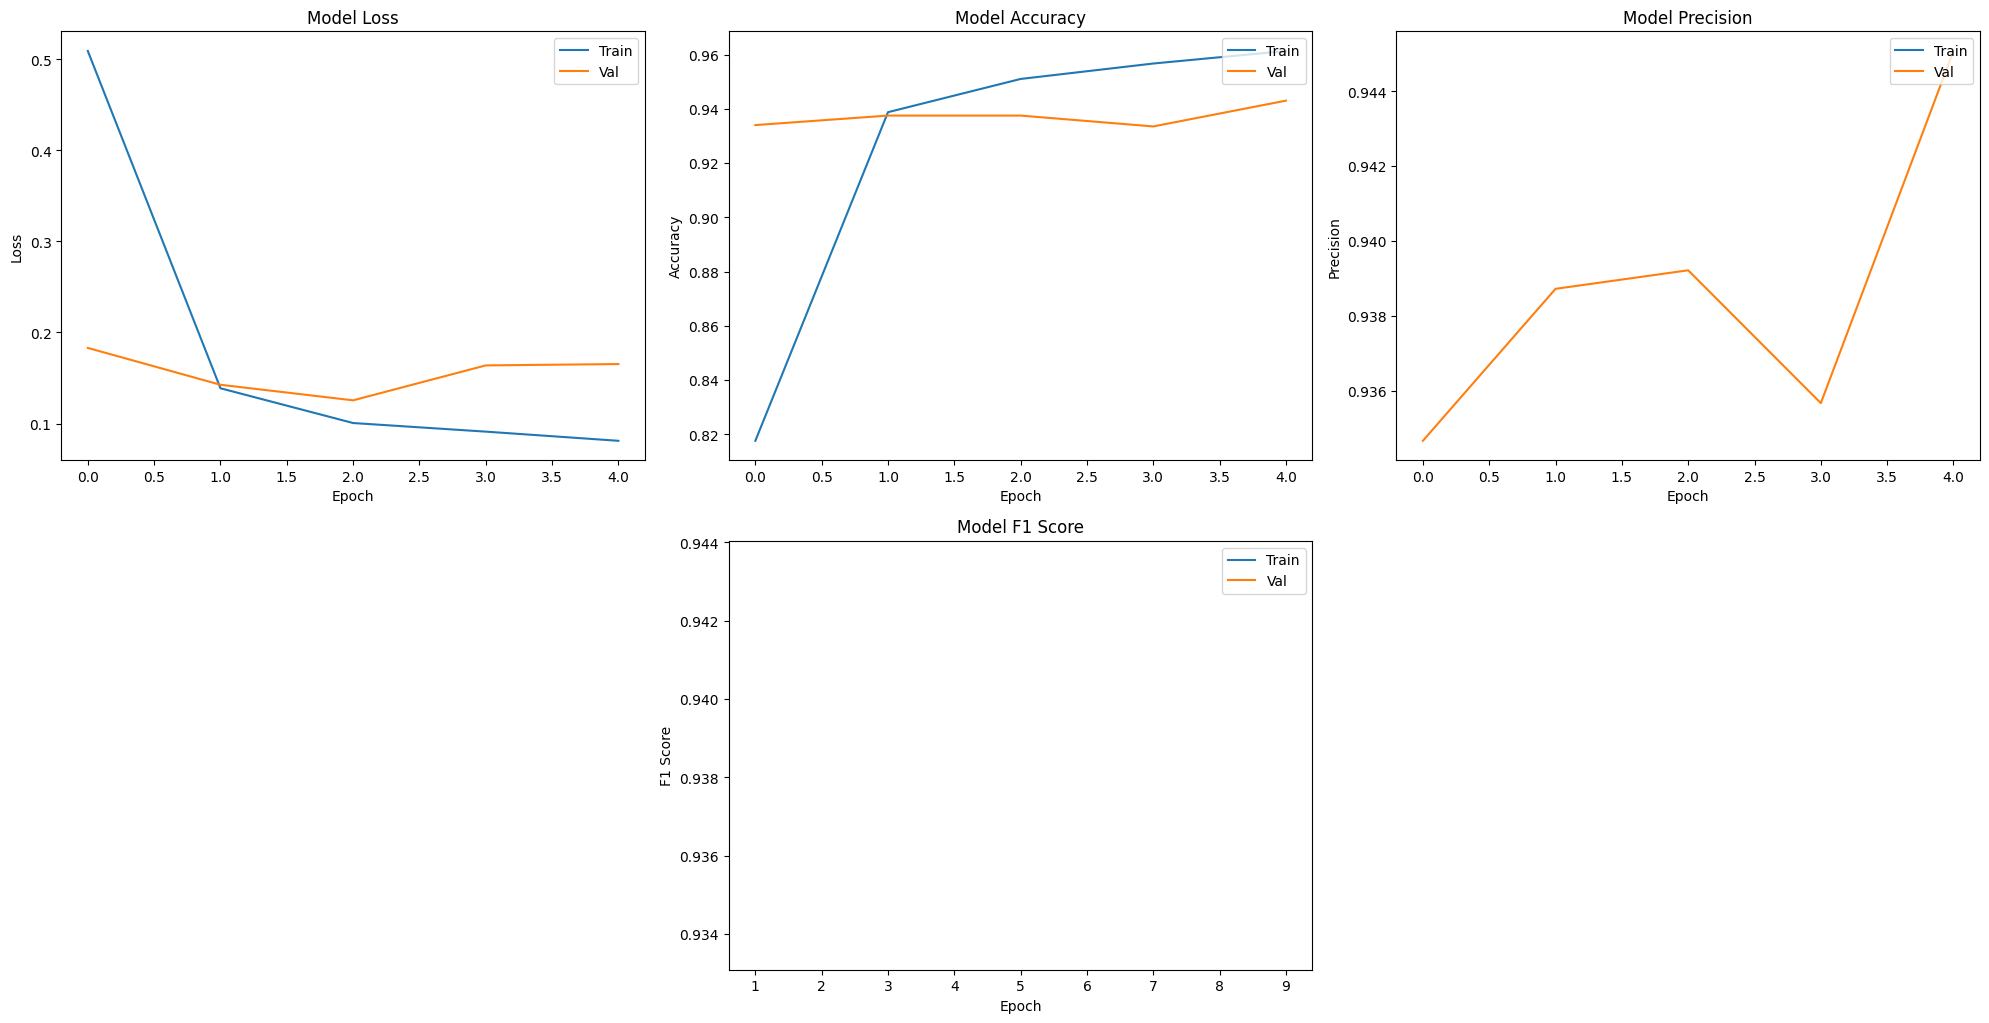

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_metric, val_metric, title, ylabel):
    plt.plot(train_metric)
    plt.plot(val_metric)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')

def multi_plot_all_metrics(dict_of_data):
    plt.figure(figsize=(20, 15))

    plt.subplot(3, 3, 1)
    plot_metrics(dict_of_data['train_loss'], dict_of_data['val_loss'], 'Model Loss', 'Loss')

    plt.subplot(3, 3, 2)
    plot_metrics(dict_of_data['train_accuracy'], dict_of_data['val_accuracy'], 'Model Accuracy', 'Accuracy')

    plt.tight_layout()
    plt.show()


# Plot the metrics
multi_plot_all_metrics(metrics_callback.metrics_data)



KeyError: 'dev_precision'

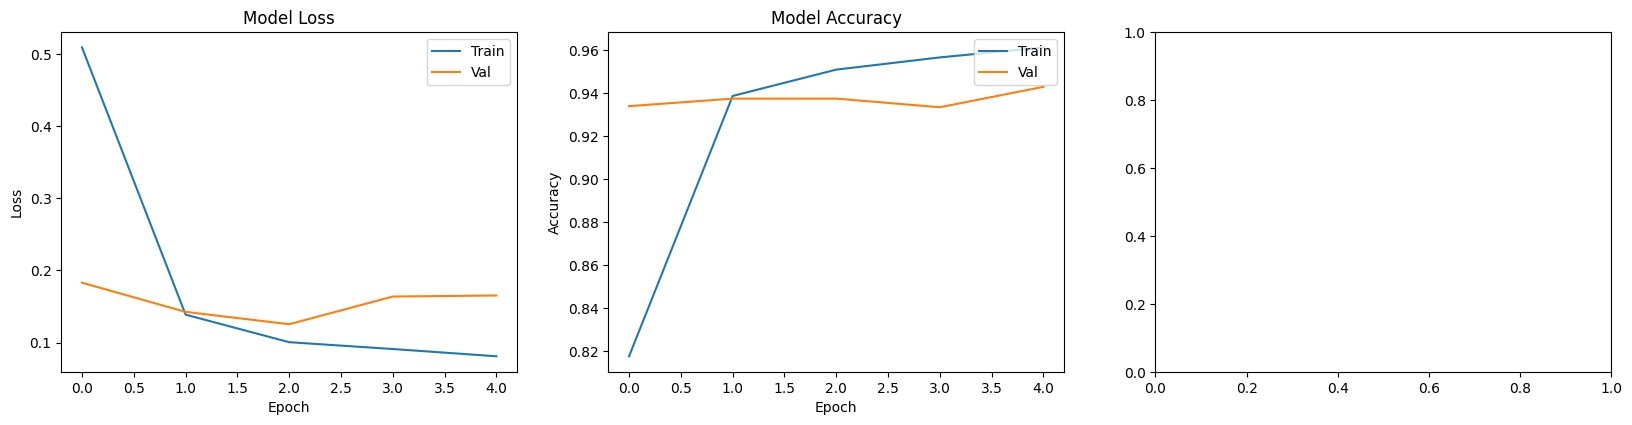

In [ ]:
# Plot the metrics
multi_plot_all_metrics(metrics_callback.metrics_data)

In [ ]:
from sklearn.metrics import classification_report

predictions = np.argmax(tf.nn.softmax(bert_clf.predict([bert_val['input_ids'],
                                                        bert_val['attention_mask']]).logits, axis=-1),
                        -1)
print(classification_report(y_val, predictions,
                            target_names=label_names))

63/63 [==============================] - 33s 519ms/step
              precision    recall  f1-score   support

     sadness       0.98      0.96      0.97       550
         joy       0.97      0.94      0.96       704
        love       0.84      0.94      0.89       178
       anger       0.93      0.96      0.95       275
        fear       0.91      0.89      0.90       212
    surprise       0.83      0.91      0.87        81

    accuracy                           0.94      2000
   macro avg       0.91      0.93      0.92      2000
weighted avg       0.95      0.94      0.94      2000



## Pre-trained Bert model with task specific layers

Add more flexibility such as extra layers, pooling mechanisms and freezing the model by creating a custom Model.

In [ ]:
from transformers import TFAutoModel

bert_backbone = TFAutoModel.from_pretrained('bert-base-uncased',)
bert_backbone.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
class BERTClassifier(tf.keras.Model):
  def __init__(self, bert, num_classes, freeze=False, apply_dropout=True):
    super().__init__()
    self.bert = bert
    self.apply_dropout = apply_dropout
    self.bert.trainable = True
    if freeze:
      # Freeze all weights. Overrides
      #self.bert.trainable = False

      # Altrenatively freeze only specific layers using their
      # coresponding index. E.g tune only last 2 layers
      for l_idx in range(len(self.bert.bert.encoder.layer.layers)-2):
        self.bert.bert.encoder.layer[l_idx].trainable = False

      # Freeze embedding layer
      self.bert.bert.embeddings.trainable = False

    self.pool = tf.keras.layers.GlobalMaxPooling1D(name='max_pool')
    self.dropout = tf.keras.layers.Dropout(0.5, name='dropout')
    self.clf = tf.keras.layers.Dense(num_classes, name='clf',
                                     activation='softmax')

  def call(self, inputs, training=None):
    # input_ids, attention_mask = inputs
    x = self.bert(inputs, training=training)
    x = self.pool(x.last_hidden_state)
    if self.apply_dropout:
        x = self.dropout(x, training=training)
    x = self.clf(x, training=training)
    return x

  def print_summary(self, line_length=None, positions=None, print_fn=None):
    # Fake forward pass to build graph
    x = np.zeros((1, 250), dtype=np.int32)
    self.predict([x, x])
    self.summary(line_length=line_length, positions=positions,
                 print_fn=print_fn)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Initialize and compile the BERTClassifier model
bert_classifier = BERTClassifier(bert_backbone,
                                 len(label_names),
                                 freeze=True,
                                 apply_dropout=True)

print(bert_classifier.print_summary())

bert_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
                        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                        metrics=[tf.keras.metrics.CategoricalAccuracy()])

# Train the BERTClassifier model
history = bert_classifier.fit(x=[bert_train['input_ids'], bert_train['attention_mask']],
                               y=y_train_1_hot,
                               batch_size=16,
                               verbose=1,
                               validation_data=([bert_val['input_ids'], bert_val['attention_mask']], y_val_1_hot),
                               shuffle=True,
                               epochs=5)



1/1 [==============================] - 39s 39s/step
Model: "bert_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model (TFBertModel  multiple                  109482240 
 )                                                               
                                                                 
 max_pool (GlobalMaxPooling  multiple                  0         
 1D)                                                             
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 clf (Dense)                 multiple                  4614      
                                                                 
Total params: 109486854 (417.66 MB)
Trainable params: 14770950 (56.35 MB)
Non-trainable params: 94715904 (361.31 MB)
______________

1000/1000 [==============================] - 457s 424ms/step - loss: 1.2025 - categorical_accuracy: 0.5667 - val_loss: 0.6197 - val_categorical_accuracy: 0.7775
Epoch 2/5
1000/1000 [==============================] - 418s 418ms/step - loss: 0.6077 - categorical_accuracy: 0.7858 - val_loss: 0.4545 - val_categorical_accuracy: 0.8475
Epoch 3/5
1000/1000 [==============================] - 411s 411ms/step - loss: 0.4319 - categorical_accuracy: 0.8469 - val_loss: 0.3605 - val_categorical_accuracy: 0.8715
Epoch 4/5
1000/1000 [==============================] - 418s 418ms/step - loss: 0.3425 - categorical_accuracy: 0.8783 - val_loss: 0.3397 - val_categorical_accuracy: 0.8805
Epoch 5/5
1000/1000 [==============================] - 418s 418ms/step - loss: 0.2767 - categorical_accuracy: 0.8982 - val_loss: 0.3302 - val_categorical_accuracy: 0.8810


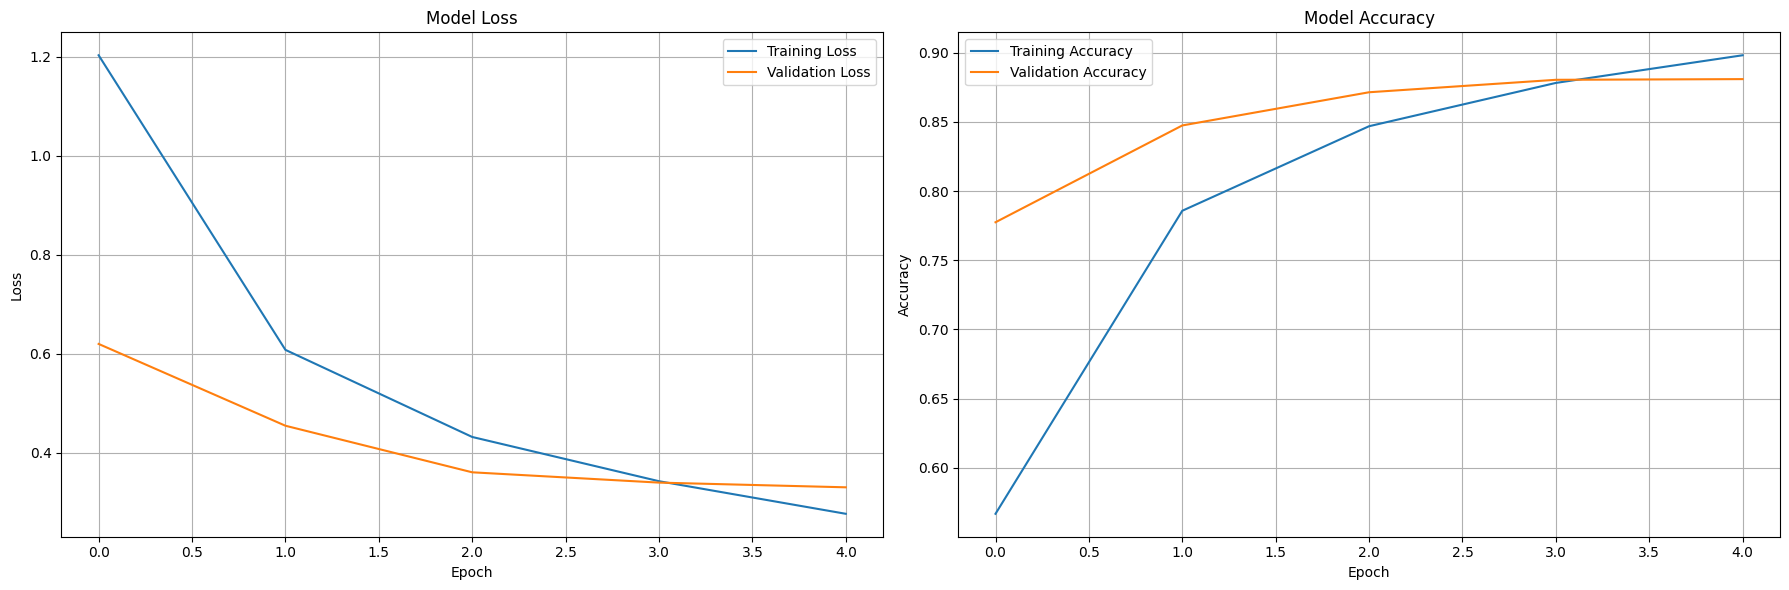

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot training & validation loss values
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')
ax1.grid(True)

# Plot training & validation accuracy values
ax2.plot(history.history['categorical_accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')
ax2.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
predictions = np.argmax(bert_classifier.predict([bert_val['input_ids'], bert_val['attention_mask']]), -1)
print(classification_report(y_val, predictions, target_names=label_names))

63/63 [==============================] - 48s 565ms/step
              precision    recall  f1-score   support

     sadness       0.90      0.92      0.91       550
         joy       0.91      0.91      0.91       704
        love       0.84      0.75      0.79       178
       anger       0.88      0.89      0.88       275
        fear       0.75      0.88      0.81       212
    surprise       0.95      0.64      0.76        81

    accuracy                           0.88      2000
   macro avg       0.87      0.83      0.85      2000
weighted avg       0.88      0.88      0.88      2000



In [ ]:
predictions = np.argmax(bert_classifier.predict([bert_test['input_ids'],
                                                        bert_test['attention_mask']]), -1)
print(classification_report(y_val, predictions, target_names=label_names))

63/63 [==============================] - 36s 569ms/step
              precision    recall  f1-score   support

     sadness       0.29      0.31      0.30       550
         joy       0.37      0.37      0.37       704
        love       0.06      0.05      0.05       178
       anger       0.11      0.11      0.11       275
        fear       0.12      0.15      0.13       212
    surprise       0.00      0.00      0.00        81

    accuracy                           0.25      2000
   macro avg       0.16      0.16      0.16      2000
weighted avg       0.25      0.25      0.25      2000



# Hyperparameter Tuning

In [ ]:
def build_model(hp):
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    num_unfrozen_layers = hp.Int('num_unfrozen_layers', min_value=2, max_value=len(bert_backbone.bert.encoder.layer.layers), step=1)
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 3e-5, 5e-5])

    # Unfreeze specified number of layers
    bert_backbone.trainable = True
    for l_idx in range(len(bert_backbone.bert.encoder.layer.layers) - num_unfrozen_layers):
        bert_backbone.bert.encoder.layer[l_idx].trainable = False
    for l_idx in range(len(bert_backbone.bert.encoder.layer.layers) - num_unfrozen_layers, len(bert_backbone.bert.encoder.layer.layers)):
        bert_backbone.bert.encoder.layer[l_idx].trainable = True

    # Initialize the BERTClassifier model
    bert_classifier = BERTClassifier(bert_backbone, len(label_names), apply_dropout=True)
    bert_classifier.dropout.rate = dropout_rate  # Adjust the dropout rate

    # Compile the model
    bert_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                            metrics=[tf.keras.metrics.CategoricalAccuracy()])

    return bert_classifier


In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
import kerastuner as kt

def model_builder(hp):
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.2)
    num_unfrozen_layers = hp.Int('num_unfrozen_layers', min_value=2, max_value=4, step=1)
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 3e-5, 5e-5])

    # Build model
    model = build_model(hp)

    return model

# Define the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_categorical_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='bert_hyperparameter_tuning')

# Define early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Start hyperparameter search
tuner.search([bert_train['input_ids'], bert_train['attention_mask']], y_train_1_hot,
             epochs=5,
             validation_data=([bert_val['input_ids'], bert_val['attention_mask']], y_val_1_hot),
             callbacks=[stop_early])


Trial 3 Complete [00h 00m 57s]

Best val_categorical_accuracy So Far: 0.9304999709129333
Total elapsed time: 00h 32m 10s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
0.2               |0.6               |dropout_rate
3                 |3                 |num_unfrozen_layers
5e-05             |1e-05             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/eng

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node bert_classifier/tf_bert_model/bert/encoder/layer_._11/intermediate/Gelu/Erf defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-35-febacb262368>", line 25, in <cell line: 25>

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 234, in search

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model

  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1804, in fit

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1381, in step_function

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1370, in run_step

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1147, in train_step

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 588, in __call__

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_file2lsgxsiw.py", line 34, in error_handler

  File "<ipython-input-11-c93bfdc6b326>", line 26, in call

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 588, in __call__

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_file2lsgxsiw.py", line 34, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1183, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 1210, in call

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_file2lsgxsiw.py", line 34, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1183, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 970, in call

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_file2lsgxsiw.py", line 34, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 604, in call

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 610, in call

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_file2lsgxsiw.py", line 34, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 549, in call

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 553, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 558, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__

  File "/tmp/__autograph_generated_file2lsgxsiw.py", line 34, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 433, in call

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/activations.py", line 453, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/activations.py", line 465, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/activations.py", line 348, in gelu

failed to allocate memory
	 [[{{node bert_classifier/tf_bert_model/bert/encoder/layer_._11/intermediate/Gelu/Erf}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_161242]


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = build_model(best_hps)

# Train the best model
history = best_model.fit([bert_train['input_ids'], bert_train['attention_mask']],
                         y=y_train_1_hot,
                         batch_size=16,
                         epochs=10,
                         validation_data=([bert_val['input_ids'], bert_val['attention_mask']], y_val_1_hot),
                         shuffle=True,
                         callbacks=[stop_early])


In [ ]:
# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot training & validation loss values
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')
ax1.grid(True)

# Plot training & validation accuracy values
ax2.plot(history.history['categorical_accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper left')
ax2.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## Evaluate best Model

In [ ]:
predictions = np.argmax(bert_classifier.predict([bert_val['input_ids'],
                                                        bert_val['attention_mask']]), -1)
print(classification_report(y_val, predictions, target_names=label_names))

In [ ]:
predictions = np.argmax(bert_classifier.predict([bert_test['input_ids'],
                                                        bert_test['attention_mask']]), -1)
print(classification_report(y_val, predictions, target_names=label_names))